In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
from src.problems.visualizations import plot_groups_results_per_gamma, plot_groups_results_std_per_alpha, plot_groups_results_means_per_alpha

In [4]:
ROOT_PATH = "results/1745502946"

cvar_results_path = f"{ROOT_PATH}/cvar_top_category_500_200_10_0.1_0.35_0.5_0.75_1_0_0.25_0.5_0.7_0.95.json"

with open(cvar_results_path, "r") as f:
    results = json.load(f)["results"]

In [ ]:
ROOT_PATH = "results/1745510212"

mean_results_path = f"{ROOT_PATH}/mean_top_category_usage_group_500_200_10_0_0.1_0.35_0.5_0.75_1_0.95.json"
min_results_path = f"{ROOT_PATH}/min_top_category_usage_group_500_200_10_0_0.1_0.35_0.5_0.75_1_0.95.json"


with open(mean_results_path, "r") as f:
    mean_results = json.load(f)["results"]

with open(min_results_path, "r") as f:
    min_results = json.load(f)["results"]

In [ ]:
mean_means = {}
min_means = {}

for gamma, vals in mean_results["top_category"]["all"]["0.95"].items():
    mean_means[gamma] = {
        "mean": np.mean([np.mean(run, axis=0) for run in vals]),
        "05": np.mean([np.quantile(run, 0.05, axis=0) for run in vals]),
        "95": np.mean([np.quantile(run, 0.95, axis=0) for run in vals]),
    }

for gamma, vals in min_results["top_category"]["all"]["0.95"].items():
    min_means[gamma] = {
        "mean": np.mean([np.mean(run) for run in vals]),
        "05": np.mean([np.quantile(run, 0.05, axis=0) for run in vals]),
        "95": np.mean([np.quantile(run, 0.95, axis=0) for run in vals]),
    }

In [ ]:
N_CONSUMERS = 500
N_PRODUCERS = 200
N_RUNS = 3
K_REC = 10

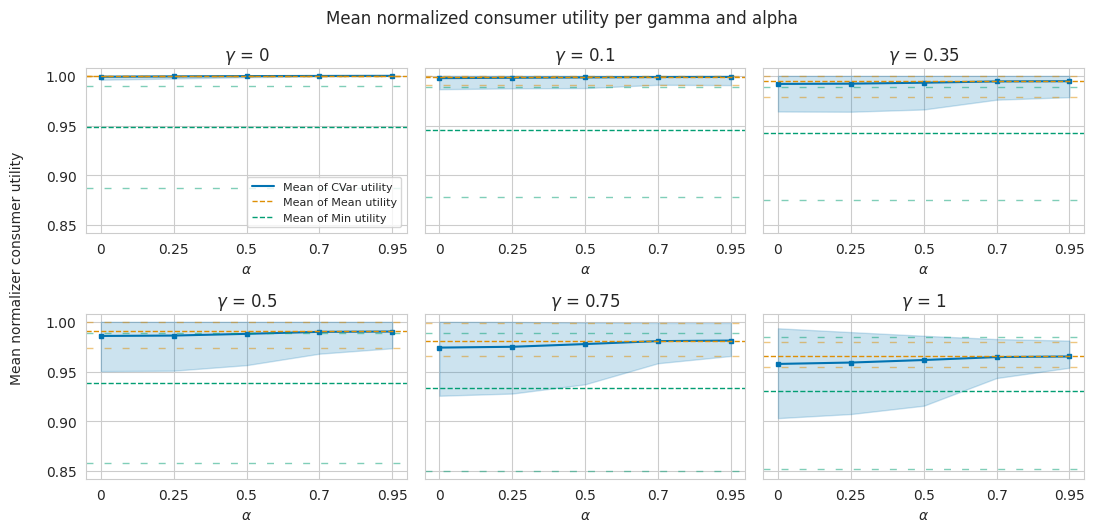

In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

def plot_groups_results_means_per_alpha(
    results: dict,
    groups_key: str,
    n_consumers: int,
    n_producers: int,
    n_runs: int,
    k_rec: int,
    mean_means: dict,
    min_means: dict,
    save_path: Path,
) -> None:
    """
    Plots mean utility ribbons per alpha for each gamma as small multiples.
    If the specified group key isn't found, falls back to 'all'.
    """
    sns.set_style("whitegrid")

    # Determine which group to plot
    if groups_key not in results:
        print(f"Warning: group '{groups_key}' not found; using 'all'.")
        group_key = 'all'
    else:
        group_key = groups_key

    # Prepare storage for percentiles
    results_per_gamma_p50 = defaultdict(lambda: defaultdict(list))
    results_per_gamma_p95 = defaultdict(lambda: defaultdict(list))
    results_per_gamma_p05 = defaultdict(lambda: defaultdict(list))

    # Aggregate percentiles per gamma and alpha
    group_results = results.get(group_key, {})
    for alpha, alpha_results in group_results.items():
        for gamma, runs in alpha_results.items():
            for run in runs:
                results_per_gamma_p50[gamma][alpha].append(
                    np.mean(run, axis=0)
                )
                results_per_gamma_p95[gamma][alpha].append(
                    np.percentile(run, axis=0, q=95)
                )
                results_per_gamma_p05[gamma][alpha].append(
                    np.percentile(run, axis=0, q=5)
                )

    # Sort the gamma keys
    sorted_gammas = sorted(results_per_gamma_p50.keys())
    n = len(sorted_gammas)
    if n == 0:
        raise ValueError(f"No gamma data found for group '{group_key}'")

    # Layout: up to 3 columns
    cols = min(3, n)
    rows = math.ceil(n / cols)

    # Create subplots grid
    fig, axes = plt.subplots(rows, cols,
                             figsize=(4 * cols, 3 * rows),
                             sharey=True)
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    palette = sns.color_palette("colorblind", 3)


    # Plot each gamma in its own subplot
    for idx, gamma in enumerate(sorted_gammas):
        ax = axes[idx]
        alphas = sorted(results_per_gamma_p50[gamma].keys())
        p50s = [np.mean(results_per_gamma_p50[gamma][a], axis=0) for a in alphas]
        p95s = [np.mean(results_per_gamma_p95[gamma][a], axis=0) for a in alphas]
        p5s  = [np.mean(results_per_gamma_p05[gamma][a], axis=0)  for a in alphas]

        # Draw the ribbon and median line
        ax.fill_between(alphas, p5s, p95s, alpha=0.2, color=palette[0])
        ax.plot(alphas, p50s, marker='s', markersize=3, color=palette[0], alpha=1, label='Mean of CVar utility')
        ax.axhline(mean_means[gamma]["mean"], linestyle='--', color=palette[1], linewidth=1, label='Mean of Mean utility')
        ax.axhline(mean_means[gamma]["05"], linestyle='--', dashes=(5, 8),  color=palette[1], linewidth=1, alpha=0.5)
        ax.axhline(mean_means[gamma]["95"], linestyle='--', dashes=(5, 8),  color=palette[1], linewidth=1, alpha=0.5)

        ax.axhline(min_means[gamma]["mean"], linestyle='--', color=palette[2], linewidth=1, label='Mean of Min utility')
        ax.axhline(min_means[gamma]["05"], linestyle='--', dashes=(5, 8),  color=palette[2], linewidth=1, alpha=0.5)
        ax.axhline(min_means[gamma]["95"], linestyle='--', dashes=(5, 8),  color=palette[2], linewidth=1, alpha=0.5)

        ax.set_title(f"$\\gamma$ = {gamma}")
        ax.set_xlabel("$\\alpha$")
        ax.set_xticks(alphas)

        if idx == 0:
            ax.legend(loc='lower right', fontsize=8, markerscale=0)

    # Hide unused subplots
    for ax in axes[n:]:
        ax.axis('off')

    # Global labels and title
    fig.suptitle("Mean normalized consumer utility per gamma and alpha", y=0.93)
    fig.text(0.04, 0.5, 'Mean normalizer consumer utility', va='center', rotation='vertical')
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

    # Ensure save directory exists
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Save to file
    filename = (
        f"cvar_small_multiples_{group_key}_n_consumers_{n_consumers}"
        f"_n_producers_{n_producers}_n_runs_{n_runs}_k_rec_{k_rec}.pdf"
    )
    #plt.legend(loc='lower right', fontsize=8, markerscale=0)
    plt.savefig(save_path / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


plot_groups_results_means_per_alpha(
    results=results["top_category"],
    groups_key="top_category",
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    n_runs=N_RUNS,
    k_rec=K_REC,
    mean_means=mean_means,
    min_means=min_means,
    save_path=Path(ROOT_PATH) / "plots",
)

Alphas: dict_keys(['0', '0.25', '0.5', '0.7', '0.95'])


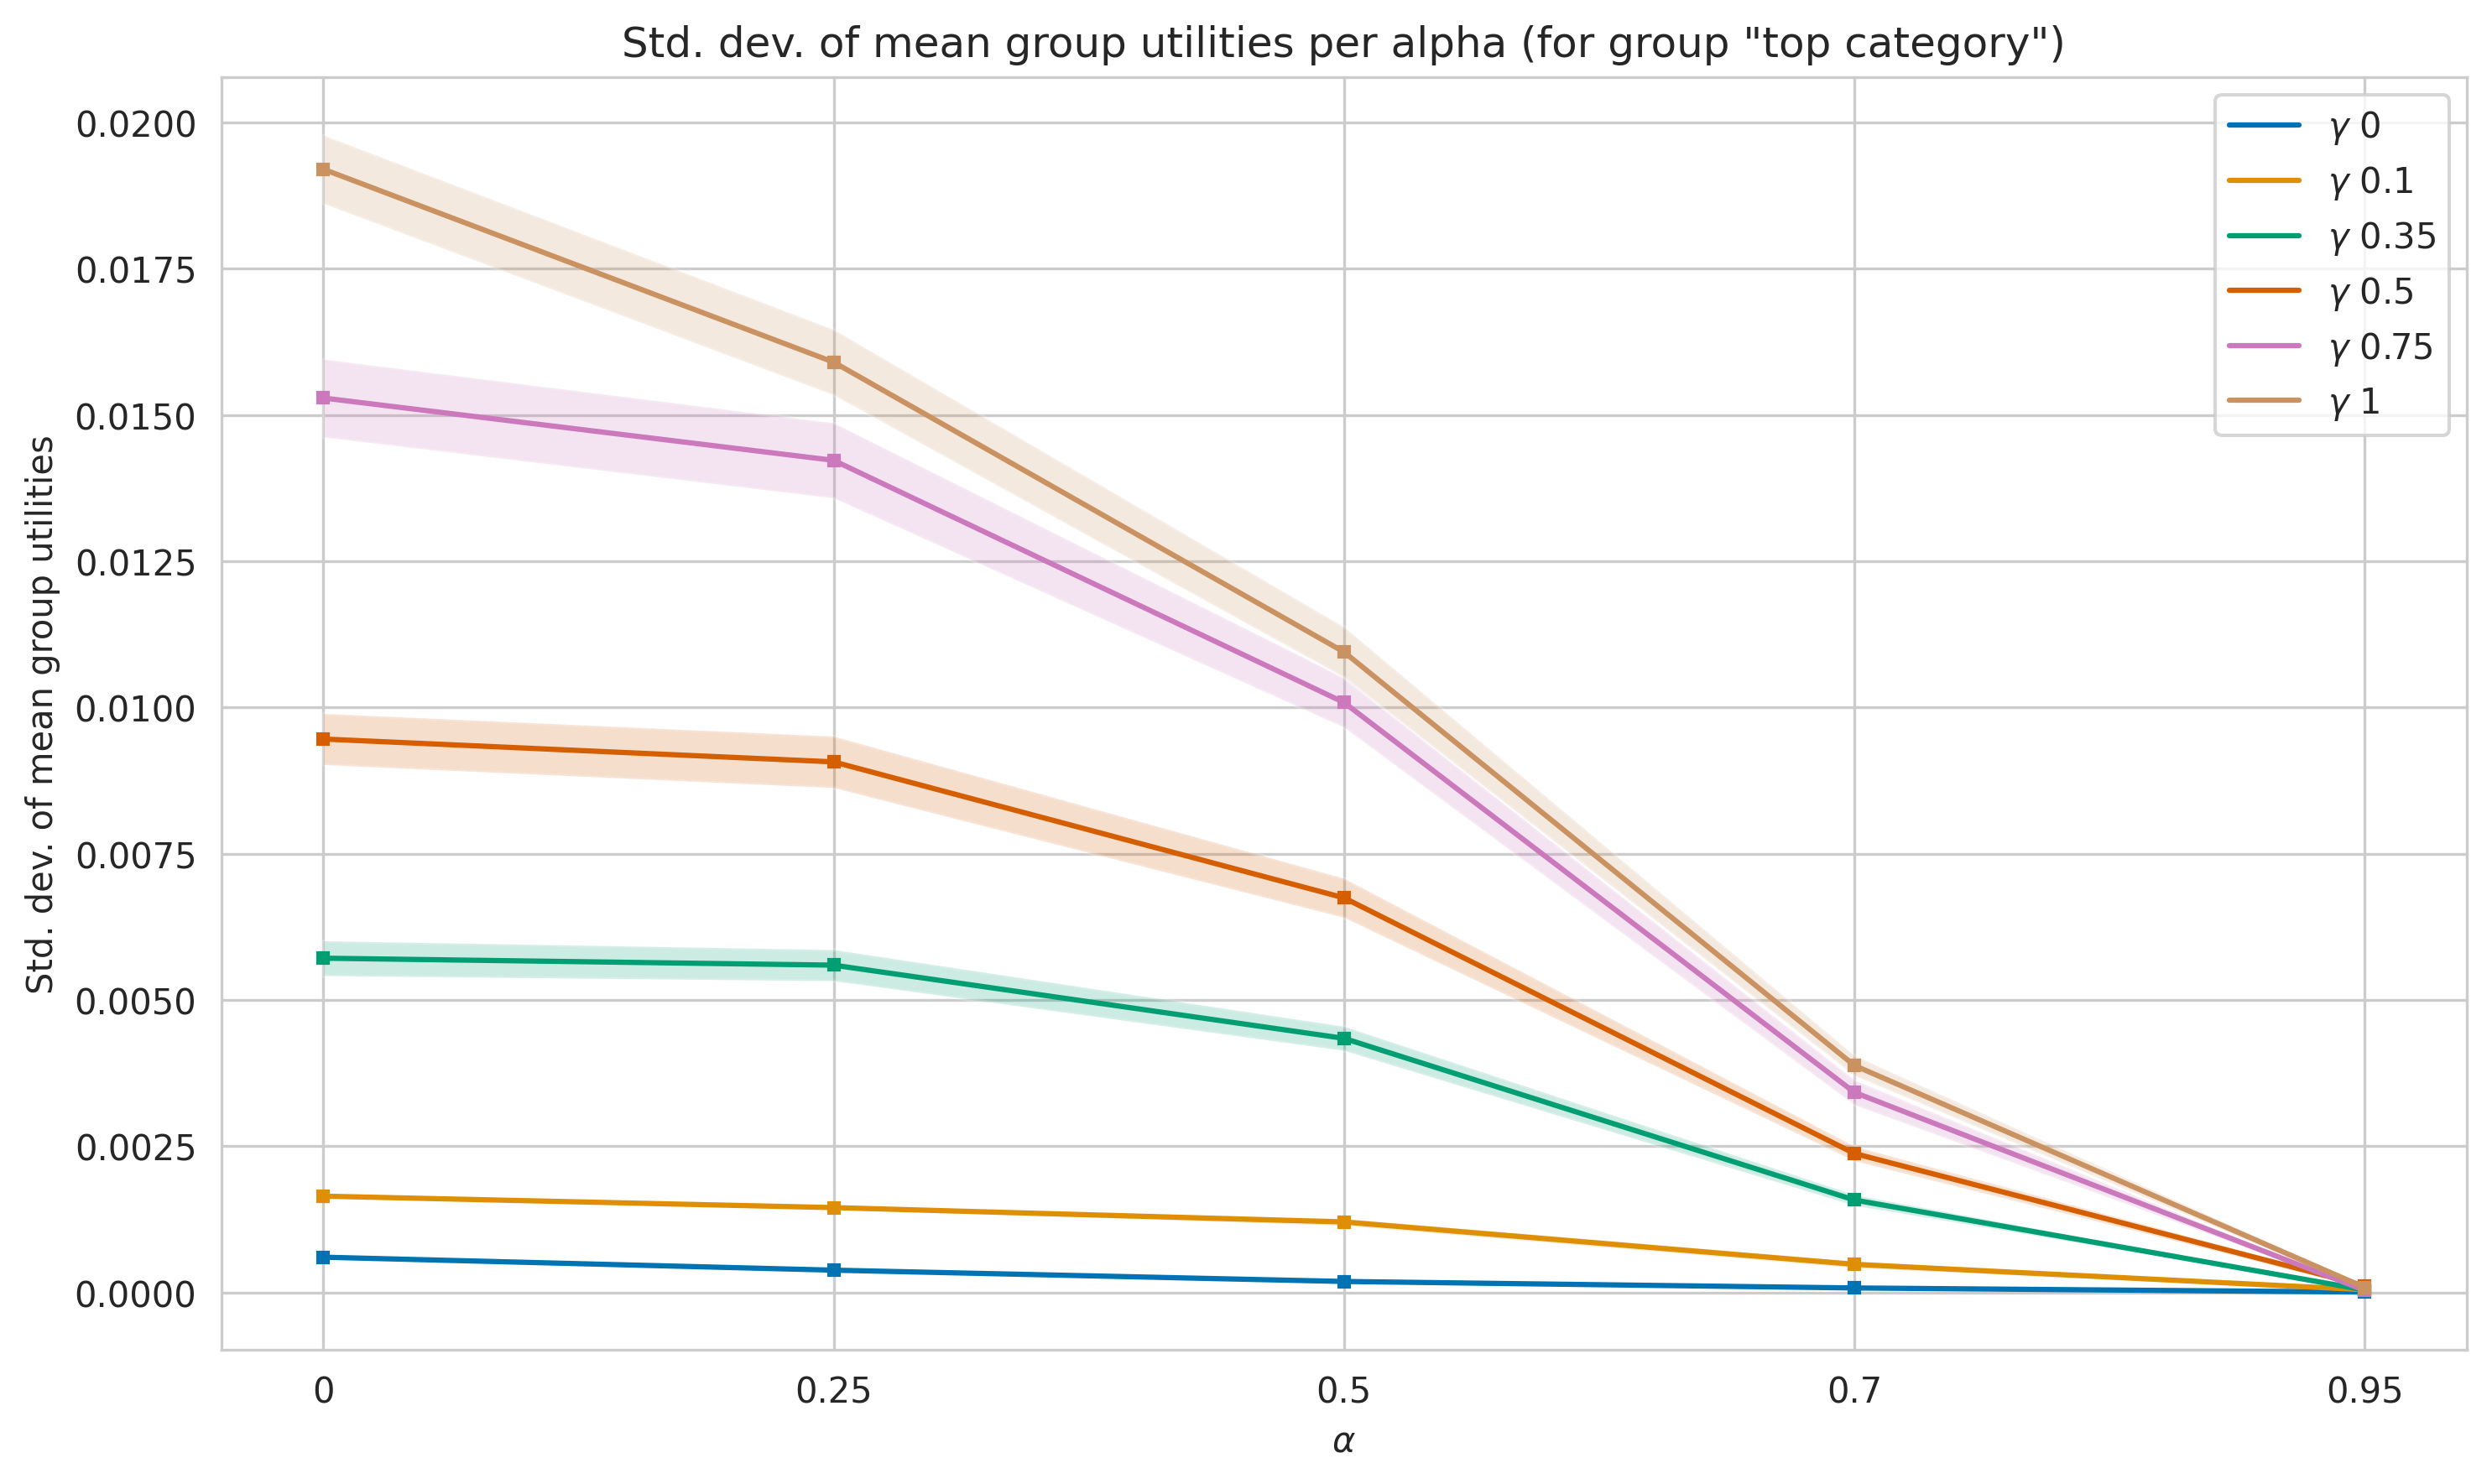

In [ ]:
plot_groups_results_std_per_alpha(
    results=results["top_category"],
    groups_key="top_category",
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    n_runs=N_RUNS,
    k_rec=K_REC,
    save_path=Path(ROOT_PATH) / "plots",
)

Alphas: dict_keys(['0', '0.25', '0.5', '0.7', '0.95'])


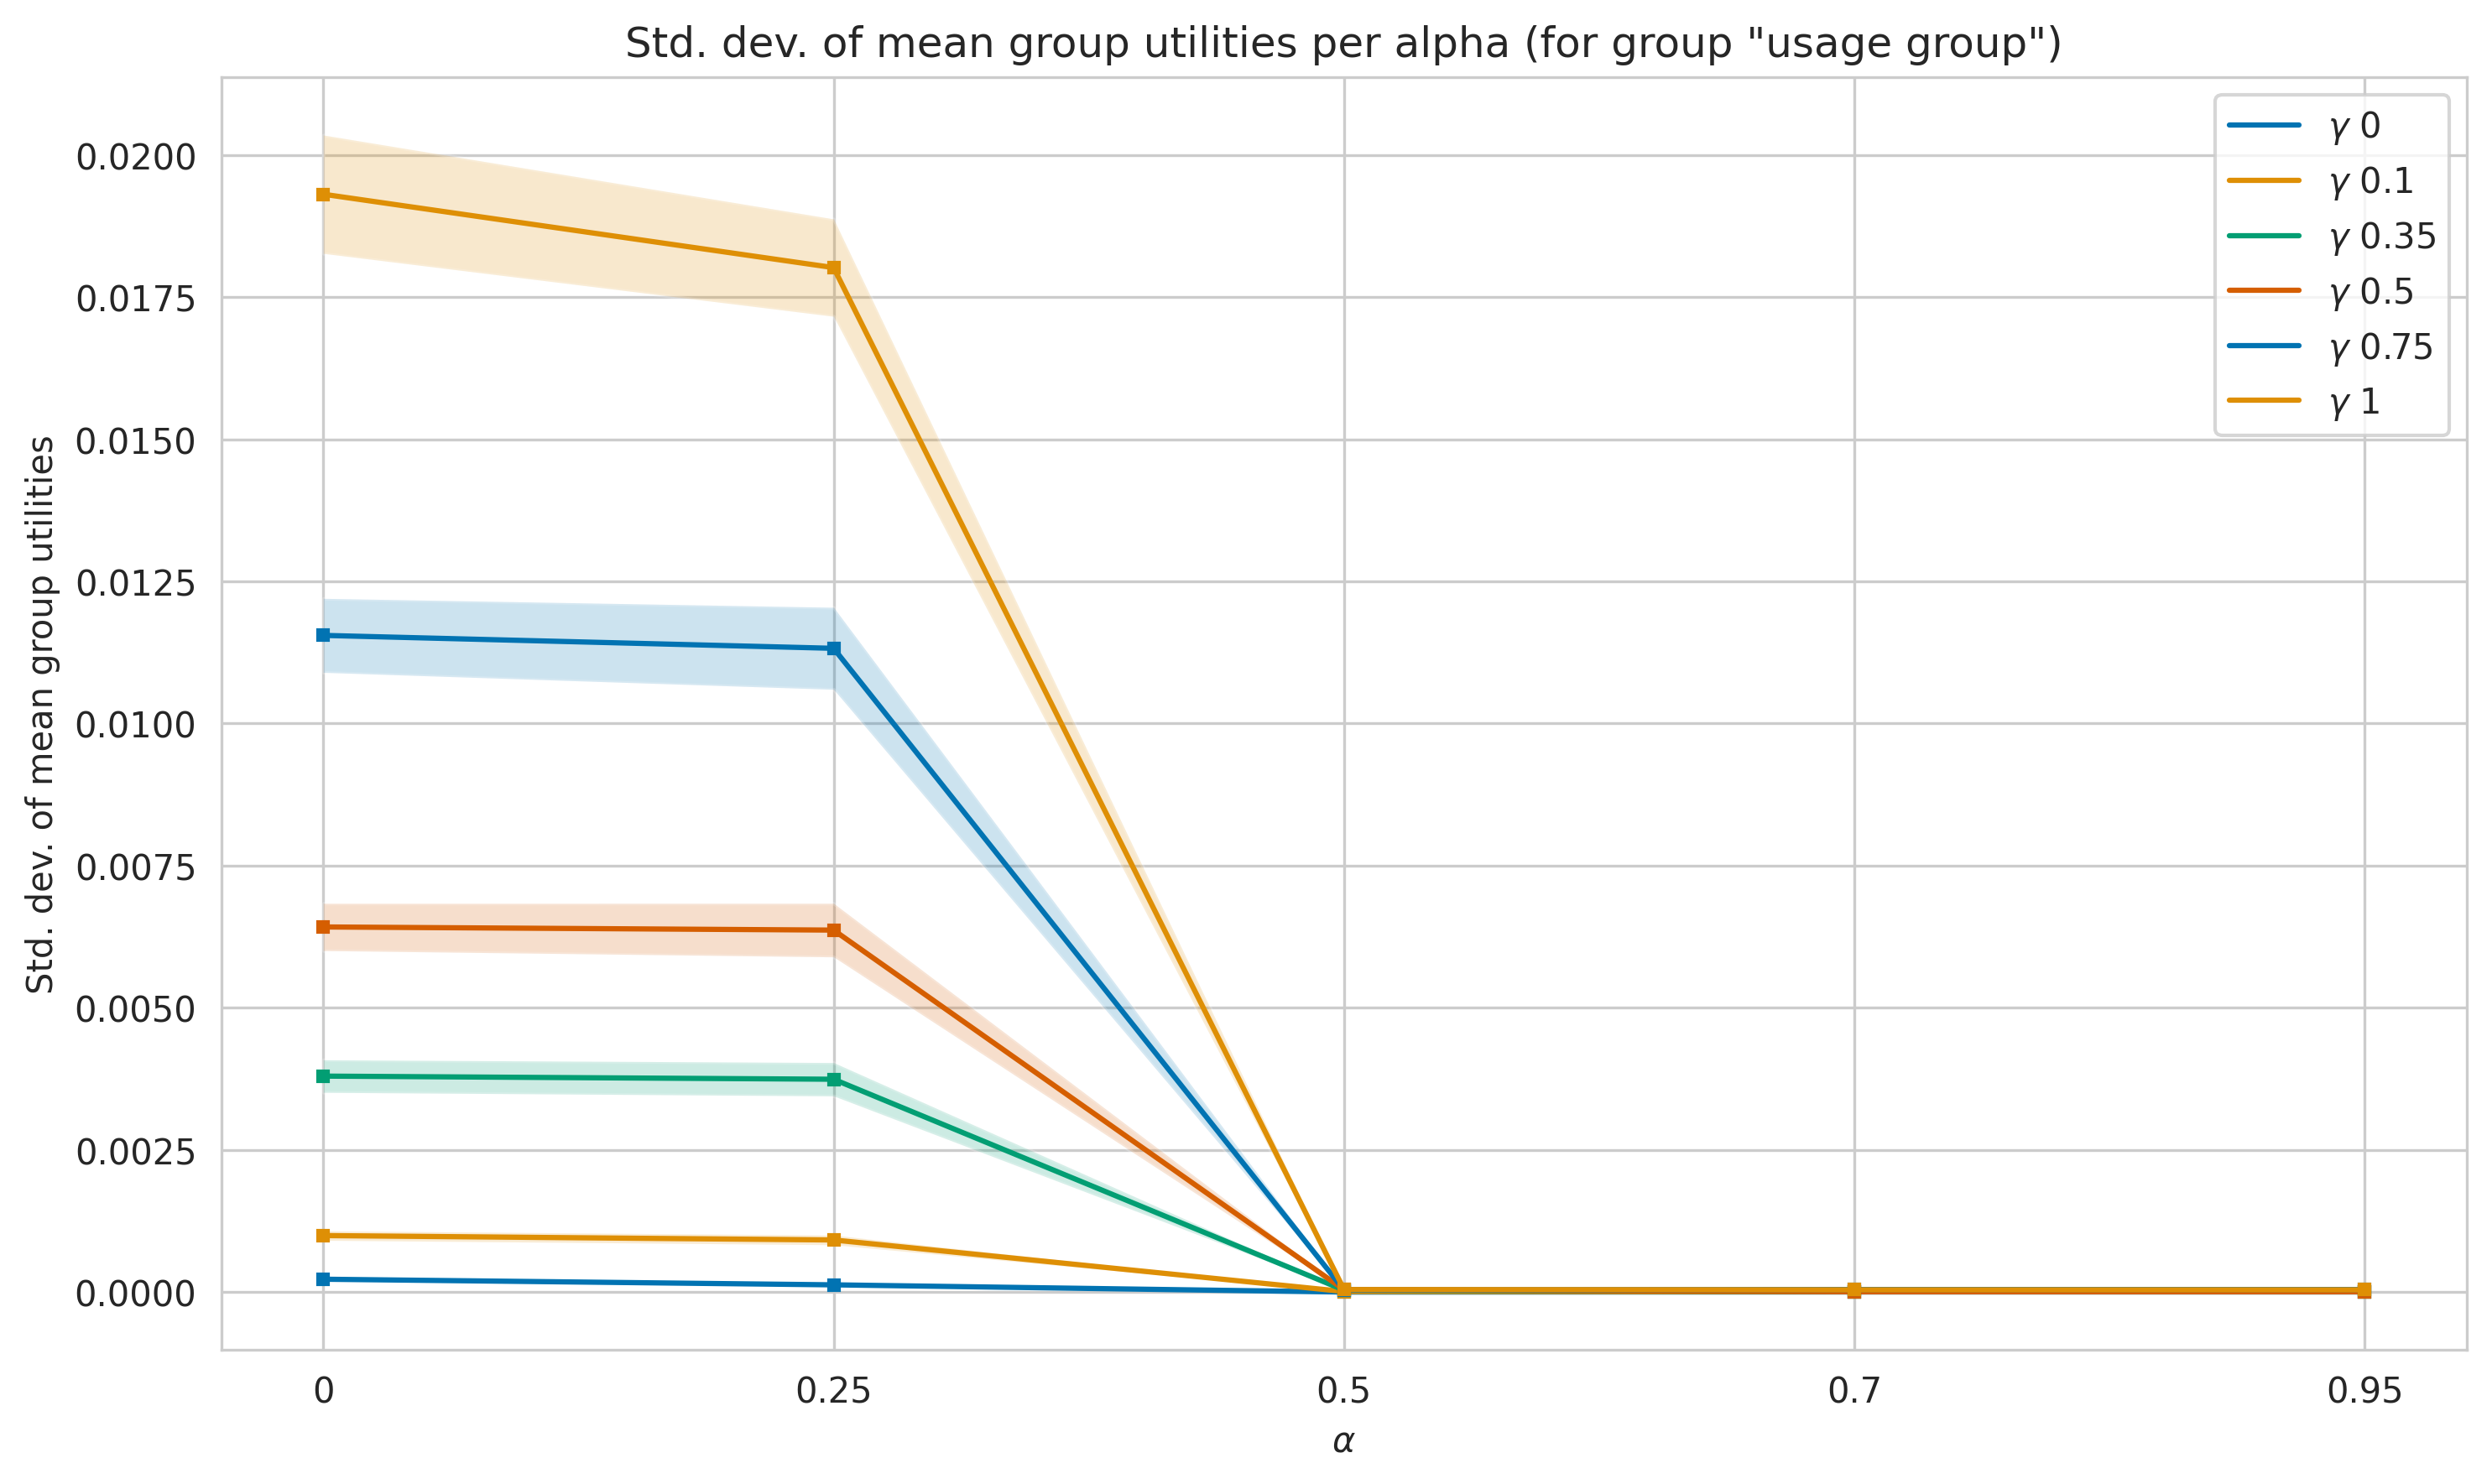

In [ ]:
ROOT_PATH = "../../results/1745518833"

cvar_results_path = f"{ROOT_PATH}/cvar_usage_group_500_200_10_0.1_0.35_0.5_0.75_1_0_0.25_0.5_0.7_0.95.json"

with open(cvar_results_path, "r") as f:
    results = json.load(f)["results"]

plot_groups_results_std_per_alpha(
    results=results["usage_group"],
    groups_key="usage_group",
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    n_runs=N_RUNS,
    k_rec=K_REC,
    save_path=Path(ROOT_PATH) / "plots",
)

In [3]:
ROOT_PATH = "results/1745525120"

with open(f"{ROOT_PATH}/min_usage_group_300_100_1_0_0.1_0.35_0.5_0.75_1_0.json", "r") as f:
    min_k1 = json.load(f)["results"]

with open(f"{ROOT_PATH}/min_usage_group_300_100_5_0_0.1_0.35_0.5_0.75_1_0.json", "r") as f:
    min_k5 = json.load(f)["results"]

with open(f"{ROOT_PATH}/min_usage_group_300_100_10_0_0.1_0.35_0.5_0.75_1_0.json", "r") as f:
    min_k10 = json.load(f)["results"]

In [9]:
res = {}
for gamma, runs in min_k1["usage_group"]["all"]["0"].items():
    res[gamma] = {
        "min": np.mean([np.min(run) for run in runs]),
        "mean": np.mean([np.mean(run) for run in runs]),
        "max": np.mean([np.max(run) for run in runs])
    }

x = [float(i) for i in res.keys()]


NameError: name 'i' is not defined